In [1]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
from scipy import interpolate

# P1.1

## Python initials


In [2]:
img = skimage.io.imread('data/campus_mine.tiff')
print("Image shape:", img.shape)
print("Image datatype:", img.dtype)
img = img.astype('double')
print("New image datatype : ", img.dtype)

Image shape: (4016, 6016)
Image datatype: uint16
New image datatype :  float64


## Linearization


In [3]:
black = 150
white = 4095

img = (img - black) / (white - black)
img = np.clip(img, 0, 1)

## Identifying the correct Bayer pattern


In [4]:
x = 0
print(img[x:x+2,x:x+2])
# Diagonal components with similar values would be the green values. From the output, we could expect that the Bayer pattern is RGGB or BGGR.

[[0.01267427 0.03954373]
 [0.05804816 0.01343473]]


In [5]:
img_shape = list(img.shape)
img_shape.append(3)
rggb, bggr, grbg, gbrg = np.zeros(img_shape), np.zeros(img_shape), np.zeros(img_shape), np.zeros(img_shape)

# Red
grbg[::2, 1::2, 0] = img[::2, 1::2]
rggb[::2, ::2, 0] = img[::2, ::2]
bggr[1::2, 1::2, 0] = img[1::2, 1::2]
gbrg[1::2, ::2, 0] = img[1::2, ::2]

# Green
grbg[::2, ::2, 1] = img[::2, ::2]
grbg[1::2, 1::2, 1] = img[1::2, 1::2]

rggb[::2, 1::2, 1] = img[::2, 1::2]
rggb[1::2, ::2, 1] = img[1::2, ::2]

bggr[::2, 1::2, 1] = img[::2, 1::2]
bggr[1::2, ::2, 1] = img[1::2, ::2]

gbrg[::2, ::2, 1] = img[::2, ::2]
gbrg[1::2, 1::2, 1] = img[1::2, 1::2]


# Blue
grbg[1::2, ::2, 2] = img[1::2, ::2]
rggb[1::2, 1::2, 2] = img[1::2, 1::2]
bggr[::2, ::2, 2] = img[::2, ::2]
gbrg[::2, 1::2, 2] = img[::2, 1::2]


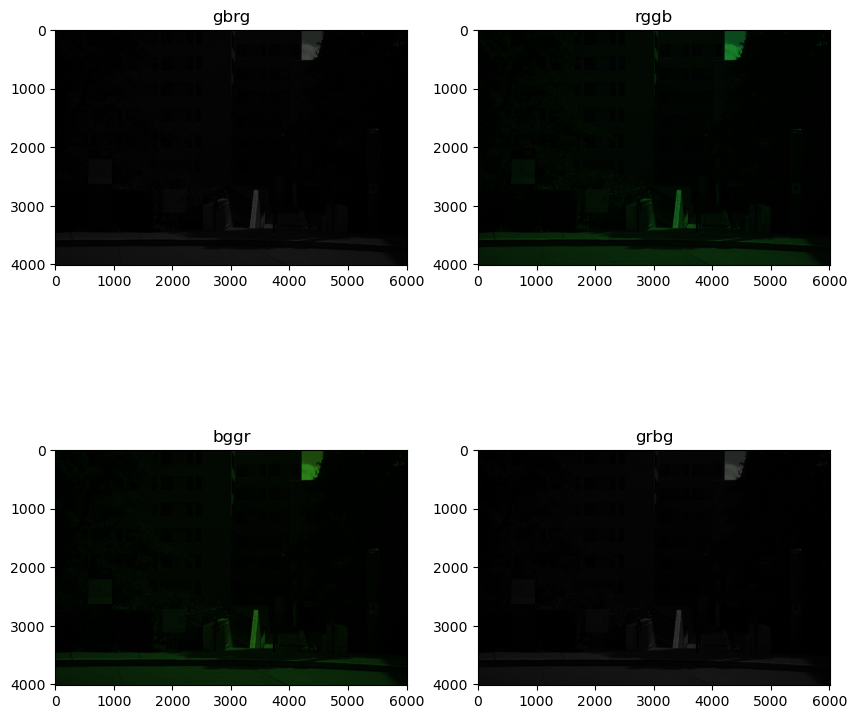

In [6]:
patterns = [(gbrg, 'gbrg'), (rggb, 'rggb'), (bggr, 'bggr'), (grbg, 'grbg')]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, (pattern, title) in zip(axs.ravel(), patterns):
    ax.imshow(pattern)
    ax.set_title(title)

plt.show()
# If we correctly arrange green values, the whole image should be greenish. From the output, we could expect that the Bayer pattern is RGGB or BGGR.

## White balancing


In [7]:
def normalize_img(img, channel_stat, target_stat):
    """Normalize image based on channel statistics."""
    norm_img = np.zeros_like(img)
    for i in range(3):
        norm_img[:,:,i] = img[:,:,i] * target_stat / channel_stat[i]
    return norm_img

def gw_white_balance(img):
    """Apply grey world normalization."""
    avg_values = [img[:,:,i].mean() for i in range(3)]
    return normalize_img(img, avg_values, avg_values[1])

def ww_white_balance(img):
    """Apply white world normalization."""
    max_values = [img[:,:,i].max() for i in range(3)]
    return normalize_img(img, max_values, max_values[1])

def dc_white_balance(img):
    """Apply dcraw scaling."""
    scales = [2.394531, 1.0, 1.597656]
    for i in range(3):
        img[:,:,i] *= scales[i]
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


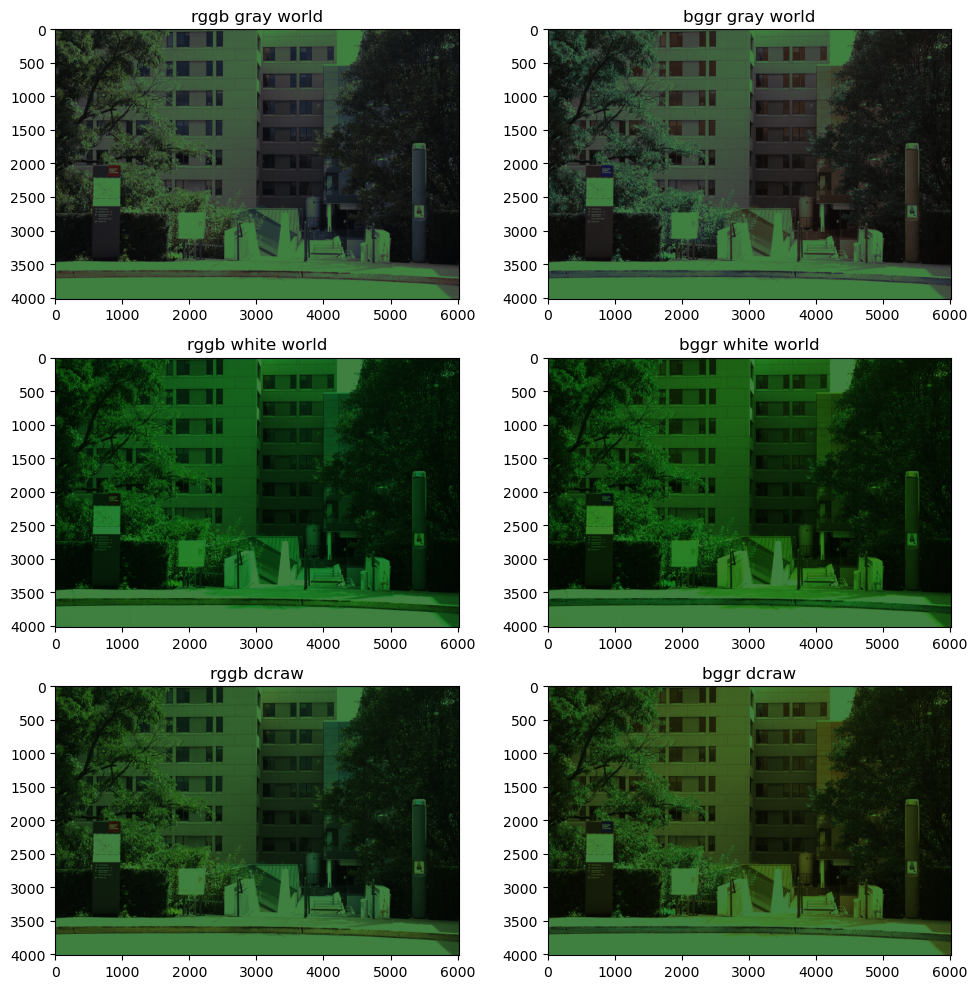

In [8]:
# Visualization
methods = [gw_white_balance, ww_white_balance, dc_white_balance]
titles = ['gray world', 'white world', 'dcraw']
patterns = [rggb, bggr]
pattern_names = ['rggb', 'bggr']

fig, axs = plt.subplots(len(methods), len(patterns), figsize=(10, 10))

for i, method in enumerate(methods):
    for j, pattern in enumerate(patterns):
        processed_img = method(pattern)
        # axs[i, j].imshow(np.clip(processed_img*5, 0, 1))
        axs[i, j].imshow(processed_img*10)
        axs[i, j].set_title(f'{pattern_names[j]} {titles[i]}')

plt.tight_layout()
plt.show()
#in 

## Demosicing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


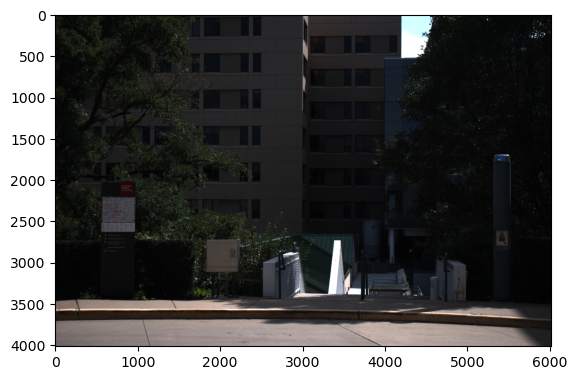

In [9]:

def demosaic_RGGB(img, gw = 0):
    """Demosaic an RGGB Bayer pattern image using scipy's interp2d."""
    # gw = 1 for gray world, 0 for white world. It decide to sum or average the two green channels.
    
    # Extract the rows and columns of the image
    rows, cols, _ = img.shape
    
    # Define the coordinates for each color in the RGGB pattern
    r_coords = (slice(0, None, 2), slice(0, None, 2))
    g1_coords = (slice(0, None, 2), slice(1, None, 2))
    g2_coords = (slice(1, None, 2), slice(0, None, 2))
    b_coords = (slice(1, None, 2), slice(1, None, 2))
    
    # Create interpolation functions for each color
    x = np.arange(0, cols, 2)
    y = np.arange(0, rows, 2)
    
    f_r = interpolate.interp2d(x, y, img[r_coords[0], r_coords[1], 0], kind='linear')
    f_g1 = interpolate.interp2d(x, y, img[g1_coords[0], g1_coords[1], 1], kind='linear')
    f_g2 = interpolate.interp2d(x, y, img[g2_coords[0], g2_coords[1], 1], kind='linear')
    f_b = interpolate.interp2d(x, y, img[b_coords[0], b_coords[1], 2], kind='linear')
    
    # Interpolate the entire image for each color
    x_new = np.arange(rows)
    y_new = np.arange(cols)
    
    img_demosaiced = np.zeros((rows, cols, 3))
    img_demosaiced[:,:,0] = f_r(y_new, x_new)
    img_demosaiced[:,:,1] = (f_g1(y_new, x_new) + f_g2(y_new, x_new))/(1 if gw else 2)
    img_demosaiced[:,:,2] = f_b(y_new, x_new)
    
    return img_demosaiced

rggb_grayworld = gw_white_balance(rggb)
img_demosaiced = demosaic_RGGB(rggb_grayworld, gw=1)

plt.imshow(img_demosaiced)
# plt.title(plot_title)
plt.show()


## Color space correction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


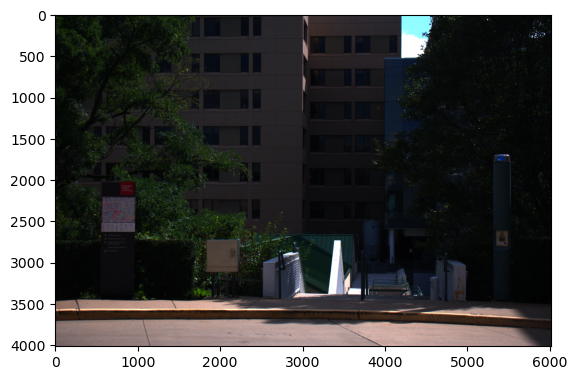

In [10]:
def color_correction(img_demosaiced):
    # Transformation matrix from dcraw file
    M_xyz2cam = np.array([
        [6988, -1384, -714],
        [-5631, 13410, 2447],
        [-1485, 2204, 7318]
    ]) / 10000.0
    
    # Standard sRGB to XYZ transformation matrix
    M_srgb2xyz = np.array([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041]
    ])
    
    # Compute the transformation matrix from sRGB to the camera's color space
    M_srgb2cam = M_xyz2cam @ M_srgb2xyz
    M_srgb2cam /= M_srgb2cam.sum(axis=1, keepdims=True)
    
    # Compute the inverse transformation matrix
    M_cam2srgb = np.linalg.inv(M_srgb2cam)
    
    # Apply the color correction
    img_cc = (M_cam2srgb @ img_demosaiced.reshape(-1, 3).T).T.reshape(img_demosaiced.shape)
    
    return img_cc

# Assuming img_demosaiced is already defined
img_cc = color_correction(img_demosaiced)
plt.imshow(img_cc)
plt.show()


## Brightness adjustment and gamma encoding

In [11]:
def linearly_scaling(img, rate):
    """Adjust the brightness of the image by linear scaling."""
    scale = rate / skimage.color.rgb2gray(img_cc).mean()  # Set post-processing scale to be 0.1 in grayscale
    return np.clip(img * scale, 0, 1)

def gamma_encoding(img):
    """Apply gamma encoding to the image."""
    mask = img <= 0.0031308
    img_gamma = np.where(mask, 12.92 * img, (1 + 0.055) * np.power(img, 1/2.4) - 0.055)
    return img_gamma


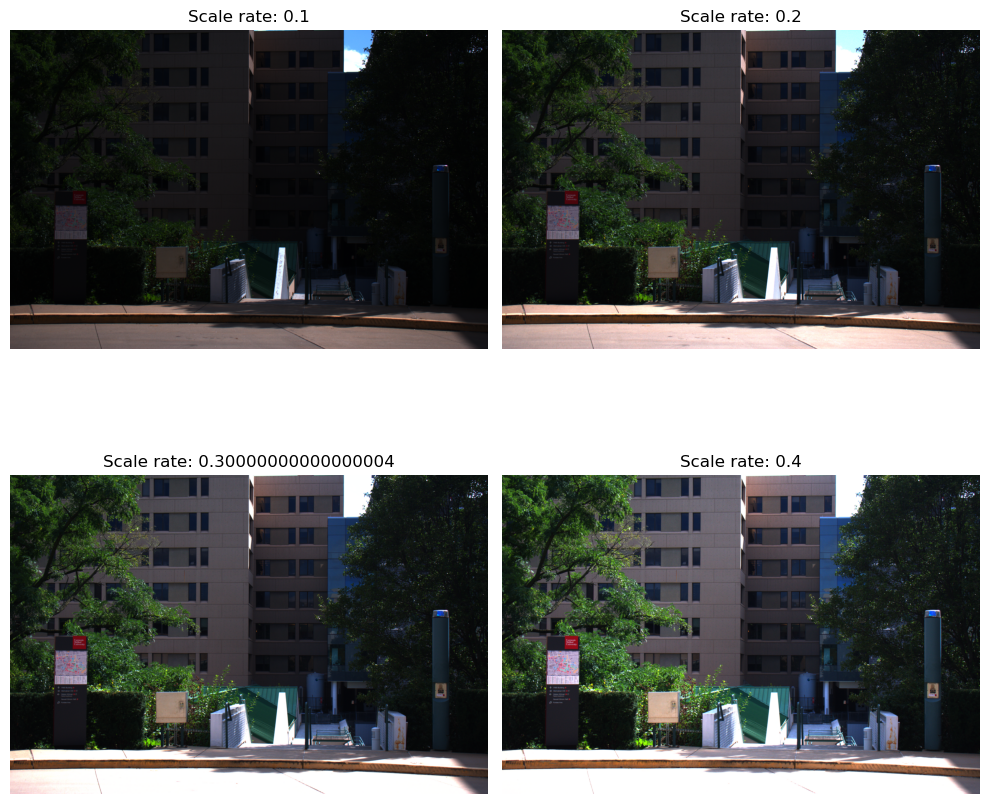

In [ ]:
#Search for correct rate for linear scaling 
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    rate = 0.1 * (i + 1)
    img_ls = linearly_scaling(img_cc, rate)
    
    ax = axs[i // 2, i % 2]  # Determine the correct subplot position
    ax.imshow(img_ls)
    ax.set_title('Scale rate: {}'.format(rate))
    ax.axis('off')  # Hide axis for better visualization

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


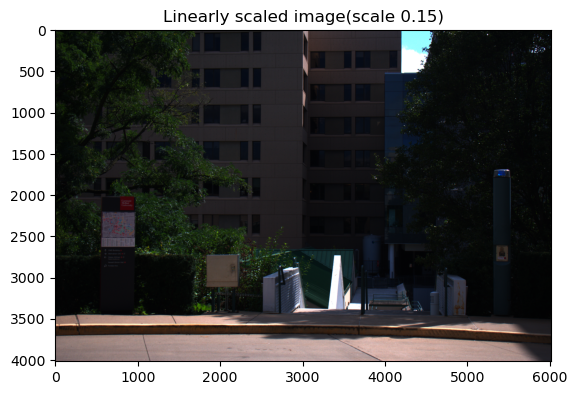

Text(0.5, 1.0, 'Image with gamma encoding')

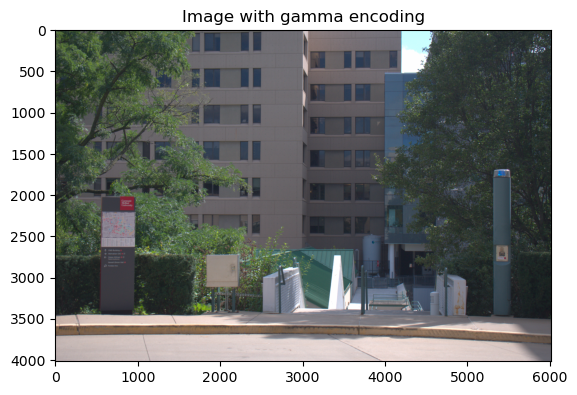

In [12]:
rate = 0.15
img_ls = linearly_scaling(img_cc, rate)
img_ge = gamma_encoding(img_ls)

plt.imshow(img_ls)
plt.title('Linearly scaled image(scale {:.2f})'.format(rate))
plt.show()
plt.imshow(img_ge)
plt.title('Image with gamma encoding')


## Compression

In [13]:
img_ge.dtype

dtype('float64')

In [48]:
# skimage.io.imsave('image_original.png', img_ge)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [14]:
# Convert the image to 8-bit format
image_final = (img_ge * 255).astype('uint8')

# Save the original image as PNG
skimage.io.imsave('saved_img/image_original.png', image_final)

# Define the desired JPEG qualities and their corresponding filenames
qualities = [95, 75, 65, 55, 45, 35, 25, 15]
for quality in qualities:
    filename = f'saved_img/image_compressioned_quality_{quality}.jpeg'
    skimage.io.imsave(filename, image_final, quality=quality)


## Save an another png file from white-world white balancing

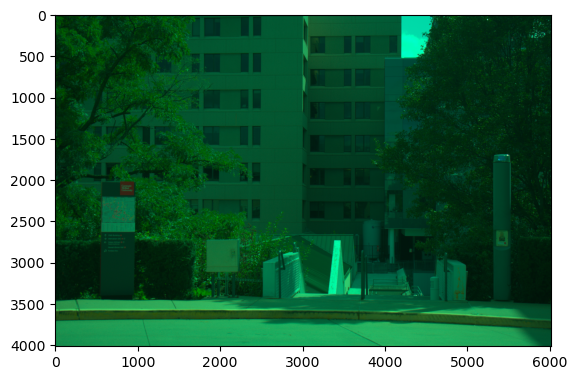

In [126]:
img_temp = ww_white_balance(rggb)
img_temp = demosaic_RGGB(img_temp, gw=0)
# plt.imshow(img_temp)
img_temp = color_correction(img_temp)
rate = 0.15
img_temp = linearly_scaling(img_temp, rate)
img_temp = gamma_encoding(img_temp)
plt.imshow(img_temp)


In [127]:
# Convert the image to 8-bit format
image_temp = (img_temp * 255).astype('uint8')

# Save the original image as PNG
skimage.io.imsave('saved_img/image_original_ww.png', image_temp)


# P1.2

In [24]:
np.save('img_ge.npy', img_ge)

In [25]:
coords = np.load('selected_coords.npy')
coords

array([[4299.24193548,  407.68064516],
       [2746.72580645,  862.51935484],
       [ 921.30645161, 2136.06774194],
       [3195.5       , 2894.13225806]])

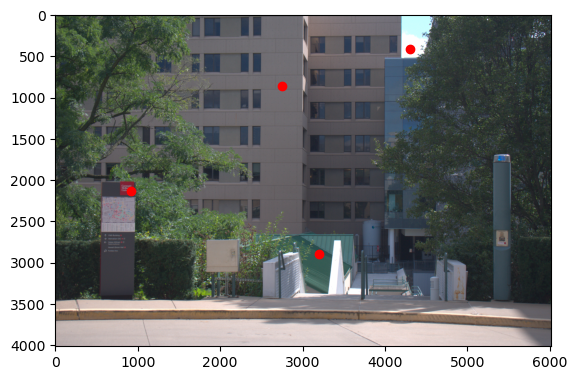

In [26]:
# Extract x and y coordinates from the points
x_coords, y_coords = zip(*coords)

# # Display the image
plt.imshow(img_ge)

# Plot the points on the image
plt.scatter(x_coords, y_coords, c='red', marker='o')

# Show the image with the points
plt.show()

In [27]:
import numpy as np

def manual_white_balance(img, patch_center, patch_size):
    """
    Perform manual white balancing on an image using a patch.
    """
    
    x, y = patch_center
    half_size = patch_size // 2

    # Extract the patch from the image
    patch = img[y-half_size:y+half_size, x-half_size:x+half_size]

    # Compute the average value for each channel in the patch
    avg_r, avg_g, avg_b = np.mean(patch, axis=(0, 1))

    # Compute the scaling factors
    scale_r = avg_g / avg_r
    scale_g = 1.0  # Green channel is the reference
    scale_b = avg_g / avg_b

    # Apply the scaling factors to the entire image
    wb_img = img.copy()
    wb_img[:, :, 0] *= scale_r
    wb_img[:, :, 1] *= scale_g
    wb_img[:, :, 2] *= scale_b

    # Clip values to the range [0, 1] or [0, 255] depending on the image data type
    if img.dtype == np.float64 or img.dtype == np.float32:
        wb_img = np.clip(wb_img, 0, 1)
    else:
        wb_img = np.clip(wb_img, 0, 255).astype('uint8')

    return wb_img

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


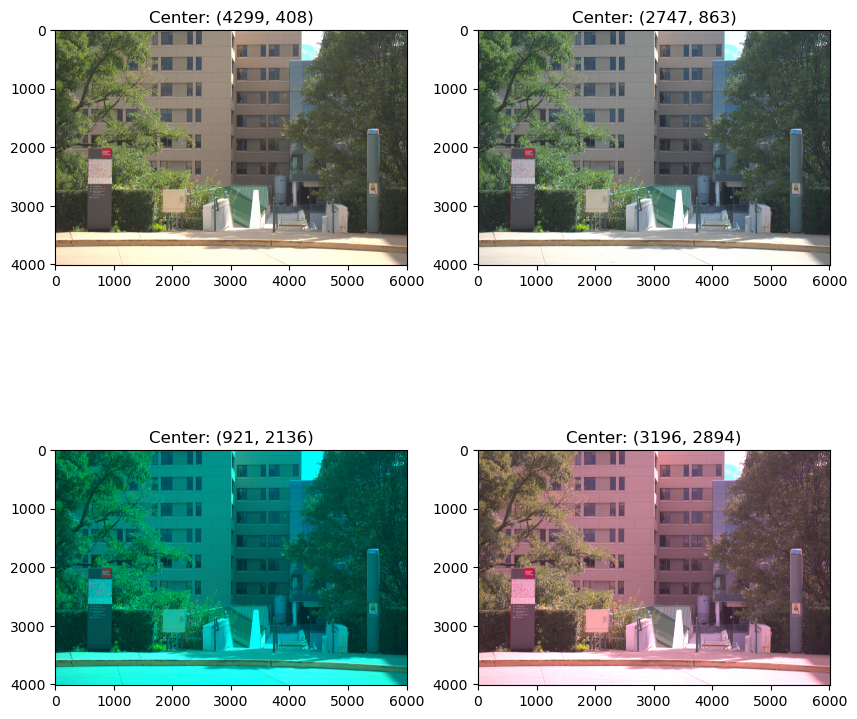

In [32]:
patch_size = 50
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(coords.shape[0]):
    x, y = coords[i]
    x = int(round(x))
    y = int(round(y))
    # print(f'Center: ({x}, {y})')
    # wb_image = manual_white_balance(img, (x, y), patch_size)
    rggb_manual = manual_white_balance(rggb, (x, y), patch_size)
    img_temp = demosaic_RGGB(rggb_manual, gw=1)
    img_temp = color_correction(img_temp)
    rate = 0.25
    img_temp = linearly_scaling(img_temp, rate)
    img_temp = gamma_encoding(img_temp)
    # plt.imshow(img_temp)
    # plt.show()
    ax = axs[i // 2, i % 2]  # Determine the correct subplot position
    ax.imshow(img_temp)
    ax.set_title(f'Center: ({x}, {y})')
    # ax.axis('off')  # Hide axis for better visualization
    skimage.io.imsave('saved_img/P1_2_image_with_manual_wb_{}.png'.format(i), img_temp)
